In [1]:
import pandas as pd
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import models
from keras import layers
import string
import copy
import seaborn as sns
sns.set()

In [2]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 10  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 27  # Maximum number of words in a sequence
GLOVE_DIM = 100  # Number of dimensions of the GloVe word embeddings

In [3]:
def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
    
def remove_mentions(input_text):
    '''
    Function to remove mentions, preceded by @, in a Pandas Series
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'@\w+', '', input_text)

Data Preprocessing

In [4]:
df = pd.read_csv('vaccination_tweets.csv')
df = df.reindex(np.random.permutation(df.index))
df = df[['text']]
df.head()

,text
1044,1st dose done. #PfizerBioNTech https://t.co/ft...
1980,Yo this medtech is vaccinated! #CovidVaccine ...
486,There’s a light at the end of the tunnel! So p...
1320,#Dubai government announced the start of a #va...
2841,Exciting times! Pleased and thankful to say th...


In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)

Train Test Split

In [7]:
X_train, X_test = train_test_split(df.text, test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
# assert X_train.shape[0] == y_train.shape[0]
# assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 4104
# Test data samples: 456


In [8]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

Creating word sequences of equal length

In [9]:
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    4104.000000
mean       12.026803
std         2.532222
min         3.000000
25%        11.000000
50%        12.000000
75%        14.000000
max        27.000000
Name: text, dtype: float64

In [10]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [11]:
X_train_seq_trunc[10]  # Example of padded sequence

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,  610,  398, 3442, 3443,   34,  508, 1043,  727,  799,
         52,    3,    2,    1, 3444], dtype=int32)

In [12]:
X_train_seq[10]

[610, 398, 3442, 3443, 34, 508, 1043, 727, 799, 52, 3, 2, 1, 3444]

In [13]:
def filter_word(sentence):
  return [word.lower() for word in nltk.word_tokenize(sentence) if word.isalnum]

def tokenize(text):
  return [filter_word(sentence) for sentence in nltk.sent_tokenize(text)]

In [14]:
import gensim
nltk.download('punkt')
text_all = list(df['text'])

sentences = []
for text in text_all:
  sentences.extend(tokenize(text))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
word2vec_model = gensim.models.Word2Vec(sentences, sg=1, min_count=10)

In [16]:
print(word2vec_model.wv.most_similar(['vaccine', 'covid']))

[('receive', 0.9812780022621155), ('first', 0.97469162940979), ('had', 0.9628421664237976), ('shipment', 0.9605128169059753), ('covid-19', 0.9602150917053223), ('just', 0.9485031962394714), ('monday', 0.9476942420005798), ('19', 0.9470436573028564), ('receiving', 0.9468523263931274), ('shot', 0.9456652998924255)]


In [17]:
print(word2vec_model.wv.similarity('vaccination', 'covid'))

0.8583291


In [18]:
print(word2vec_model.wv.similarity('vaccination', 'vaccination'))

1.0


In [19]:
vocab = list(word2vec_model.wv.vocab)
print(len(vocab))

801


In [20]:
count = {'punc': 0, 'digit': 0, 'abnormal': 0}
for i in range(len(vocab)):
  if vocab[i] in string.punctuation:
    # print('punctuation: ', vocab[i], ' removed')
    vocab[i] = ''
    count['punc'] += 1
  elif vocab[i].isdigit():
    # print('digit: ', vocab[i], ' removed')
    vocab[i] = ''
    count['digit'] += 1
  elif any(p in vocab[i] for p in string.punctuation):
    # print('abnormal: ', vocab[i], ' removed')
    vocab[i] = ''
    count['abnormal'] += 1
  else:
    pass
    # print(vocab[i])

In [21]:
print(count)
print(sum(count.values()))
print(len(vocab))

{'punc': 14, 'digit': 21, 'abnormal': 26}
61
801


In [22]:
for i in range(sum(count.values())):
  vocab.remove('')
print(len(vocab))

740


In [23]:
%matplotlib inline
# %matplotlib notebook
# import mpld3
# mpld3.enable_notebook()
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

# instantiate a PCA object
pca = PCA(n_components=2)
# fit and transform the PCA object
my_pca = pca.fit_transform(word2vec_model[vocab])

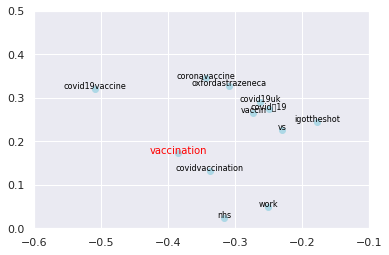

In [31]:
x1 = 'vaccination'
ind1 = vocab.index(x1)
neighbor1 = []
for i in range(len(vocab)):
  if word2vec_model.wv.similarity(x1, vocab[i]) > 0.965:
    neighbor1.append(i)

# plot the data
plt.scatter(my_pca[neighbor1, 0], my_pca[neighbor1, 1], alpha=1, color='lightblue')
# annotate plot
for i, word in enumerate(vocab):
  # if len(word) < 2:
  #   break
  if i in neighbor1:
    if i == ind1:
      plt.annotate(x1, xy=(my_pca[ind1, 0], my_pca[ind1, 1]), color='red', ha='center')
    else:
      plt.annotate(word, xy=(my_pca[i, 0], my_pca[i, 1]), color='black', size=8, ha='center')
  else:
    continue
plt.axis((-0.6, -0.1, 0, 0.5))
plt.show();

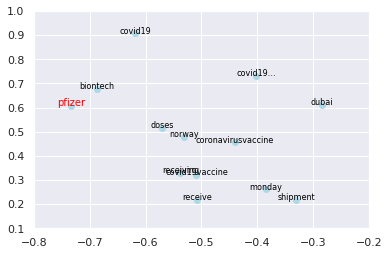

In [29]:
x2 = 'pfizer'
ind2 = vocab.index(x2)
neighbor2 = []
for i in range(len(vocab)):
  if word2vec_model.wv.similarity(x2, vocab[i]) > 0.94:
    neighbor2.append(i)

# plot the data
plt.scatter(my_pca[neighbor2, 0], my_pca[neighbor2, 1], alpha=1, color='lightblue')
# annotate plot
for i, word in enumerate(vocab):
  # if len(word) < 2:
  #   break
  if i in neighbor2:
    if i == ind2:
      plt.annotate(x2, xy=(my_pca[ind2, 0], my_pca[ind2, 1]), color='red', ha='center')
    else:
      plt.annotate(word, xy=(my_pca[i, 0], my_pca[i, 1]), color='black', size=8, ha='center')
  else:
    continue
plt.axis((-0.8, -0.2, 0.1, 1.0))
plt.show();

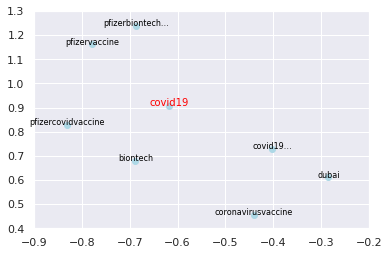

In [30]:
x3 = 'covid19'
ind3 = vocab.index(x3)
neighbor3 = []
for i in range(len(vocab)):
  if word2vec_model.wv.similarity(x3, vocab[i]) > 0.96:
    neighbor3.append(i)

# plot the data
plt.scatter(my_pca[neighbor3, 0], my_pca[neighbor3, 1], alpha=1, color='lightblue')
# annotate plot
for i, word in enumerate(vocab):
  # if len(word) < 2:
  #   break
  if i in neighbor3:
    if i == ind3:
      plt.annotate(x3, xy=(my_pca[ind3, 0], my_pca[ind3, 1]), color='red', ha='center')
    else:
      plt.annotate(word, xy=(my_pca[i, 0], my_pca[i, 1]), color='black', size=8, ha='center')
  else:
    continue
plt.axis((-0.9, -0.2, 0.4, 1.3))
plt.show();

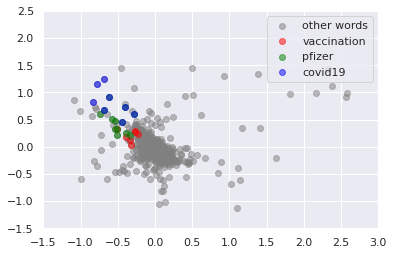

In [27]:
# plot the data
# fig , ax = plt.subplot()
plt.scatter(my_pca[:, 0], my_pca[:, 1], alpha=0.5, color='gray', label='other words')
plt.scatter(my_pca[neighbor1, 0], my_pca[neighbor1, 1], alpha=0.5, color='red', label=x1)
plt.scatter(my_pca[neighbor2, 0], my_pca[neighbor2, 1], alpha=0.5, color='green', label=x2)
plt.scatter(my_pca[neighbor3, 0], my_pca[neighbor3, 1], alpha=0.5, color='blue', label=x3)
# annotate plot
# for i, word in enumerate(vocab):
#   if len(word) < 2:
#     break
#   plt.annotate(word, xy=(my_pca[i, 0], my_pca[i, 1]), fontsize=5, size=5)

plt.axis((-1.5, 3, -1.5, 2.5))
plt.legend()
plt.show();
# mpld3.display()